**FABÍOLA ANDRADE SOUZA**

**UFPR - TRABALHO FINAL DA DISCIPLINA TÓPICOS 3 - IA GEOESPACIAL E PLN / 2024.1**

**TREINAMENTO DO MODELO RoBERTa PARA ASSOCIAÇÃO SEMÂNTICA DE ESQUEMAS DE DADOS GEOESPACIAIS**

In [1]:
# Instala as bibliotecas necessárias
!pip install transformers[torch] accelerate -U
!pip install datasets

# Reinstalar a versão específica do `requests` exigida pelo Google Colab
!pip install requests==2.31.0


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [17]:
#Importa as bibliotecas para uso
from transformers import Trainer, TrainingArguments, RobertaTokenizer, RobertaForSequenceClassification, DataCollatorWithPadding
from datasets import Dataset, DatasetDict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import label_binarize


In [3]:
#Criação do drive para acesso aos dados
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Carrega base de dados do Google Drive
df = pd.read_excel('/content/drive/My Drive/Colab_Notebooks/Topicos3/Trabalho/machado_dominios.xlsx')

#Na planilha, a coluna ROTULO = 1 indica uma associação que está correta entre as demais colunas (domínio da ET-EDGV e value do OSM).
#O ROTULO = 0 indica uma associação errada ou impossível e o ROTULO = 2 indica uma associação coerente, mas não necessariamente correta.


In [5]:
# Prepara os dados / para manter uma associação de maneira única na entrada de dados
df['associa'] = df[df.columns[:2]].astype(str).agg(' - '.join, axis=1) #Junta as colunas (dominio e value) em uma só, gerando um texto de associação semântica
df['rotulo'] = df[df.columns[2]].astype(int)  # Convertendo o rótulo para inteiros
df = df[['associa', 'rotulo']]  # Mantendo apenas as colunas de texto associado e rótulos de classificação


In [6]:
print(df['rotulo'].value_counts()) #Conta a qtd de cada rótulo

rotulo
0    262
1     58
2     31
Name: count, dtype: int64


In [7]:
df

,associa,rotulo
0,Banco - terminal,0
1,Biblioteca - terminal,0
2,Curral - terminal,0
3,Hotel - terminal,0
4,Mesquita - terminal,0
...,...,...
346,Biblioteca - viewpoint,0
347,Curral - viewpoint,0
348,Hotel - viewpoint,0
349,Mesquita - viewpoint,0


In [8]:
# Divide os dados em treino e teste
train_df = df.sample(frac=0.70, random_state=42) #Fração 70% a 30%
test_df = df.drop(train_df.index)

# Converter para o formato de Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
dataset = DatasetDict({'train': train_dataset, 'test': test_dataset})


In [9]:
# Carrega o tokenizer do modelo RoBERTa
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=df['rotulo'].nunique())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
#Tokenizar os dados a partir do modelo RoBERTa pré-treinado para classificação de sequência.
#A opção truncation=True corta os textos que são mais longos do que o limite de comprimento do modelo.
#E padding='max_length' adiciona preenchimento para garantir que todos os tokens tenham o comprimento máximo de 128, para facilitar o processamento matricial dos tokens.

def tokenize_function(examples):
    return tokenizer(examples['associa'], truncation=True, padding='max_length', max_length=128)

#Aplica a função de tokenização ao dataset em lotes.
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Cria um data collator que vai cuidar do preenchimento dos tokens, garantindo que todos os exemplos em um lote tenham o mesmo comprimento durante o treinamento.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Adicionar os rótulos ao conjunto de dados tokenizado
tokenized_datasets = tokenized_datasets.map(lambda examples: {'labels': examples['rotulo']}, batched=True)


Map:   0%|          | 0/246 [00:00<?, ? examples/s]

Map:   0%|          | 0/105 [00:00<?, ? examples/s]

Map:   0%|          | 0/246 [00:00<?, ? examples/s]

Map:   0%|          | 0/105 [00:00<?, ? examples/s]

In [11]:
# Função de métricas usada no treinamento para cada época...

def compute_metrics(p):
    predictions, labels = p  #Saída do modelo - predictions é a probabilidade para cada classe e labels é o valor verdadeiro.
    preds = np.argmax(predictions, axis=1)  #Converte as probabilidades de saída do modelo nas classes previstas, pegando o índice da classe com a maior probabilidade para cada exemplo.
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    #average='weighted' indica que as métricas são calculadas para uma tarefa com base nos pesos. Pode ser {‘binary’, ‘micro’, ‘macro’, ‘samples’, ‘weighted’}, default=None
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc, #Calcula a acurácia, que é a fração de previsões corretas sobre o total de previsões.
        'f1': f1, #A média harmônica da precisão e recall, proporcionando uma medida equilibrada das duas métricas.
        'precision': precision, #A fração de exemplos previstos como positivos que são realmente positivos.
        'recall': recall #A fração de exemplos positivos verdadeiros que foram corretamente identificados pelo modelo.
    }


In [12]:
# Configurações de treinamento
training_args = TrainingArguments( #Parâmetros do treinamento
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5, #A taxa de aprendizado define a magnitude dos ajustes feitos aos pesos do modelo a cada passo de otimização.
    #Se o modelo não estiver convergindo (a perda não estiver diminuindo), você pode diminuir a taxa de aprendizado. Se estiver convergindo muito lentamente, você pode aumentá-la.
    per_device_train_batch_size=10, #Número de exemplos por lote durante o treinamento / aumentei de 8 para 10
    per_device_eval_batch_size=10,
    num_train_epochs=6, #Qtd de épocas / quanto mais épocas melhor os resultados...
    weight_decay=0.01, # Taxa de decaimento de peso
)


trainer = Trainer(
    model=model, #Modelo RoBERTa
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
# Treinar o modelo
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.832761,0.657143,0.521182,0.431837,0.657143
2,No log,0.673136,0.761905,0.701047,0.660865,0.761905
3,No log,0.397077,0.876190,0.866799,0.878857,0.876190
4,No log,0.388373,0.895238,0.888438,0.894164,0.895238
5,No log,0.386957,0.885714,0.878741,0.880762,0.885714


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.832761,0.657143,0.521182,0.431837,0.657143
2,No log,0.673136,0.761905,0.701047,0.660865,0.761905
3,No log,0.397077,0.876190,0.866799,0.878857,0.876190
4,No log,0.388373,0.895238,0.888438,0.894164,0.895238
5,No log,0.386957,0.885714,0.878741,0.880762,0.885714
6,No log,0.383256,0.895238,0.888438,0.894164,0.895238


TrainOutput(global_step=150, training_loss=0.3556993357340495, metrics={'train_runtime': 1711.3219, 'train_samples_per_second': 0.862, 'train_steps_per_second': 0.088, 'total_flos': 97088851141632.0, 'train_loss': 0.3556993357340495, 'epoch': 6.0})

In [14]:
# Avaliar o modelo
eval_results = trainer.evaluate()


In [15]:
eval_results


{'eval_loss': 0.38325610756874084,
 'eval_accuracy': 0.8952380952380953,
 'eval_f1': 0.888437862950058,
 'eval_precision': 0.894164188752424,
 'eval_recall': 0.8952380952380953,
 'eval_runtime': 30.9537,
 'eval_samples_per_second': 3.392,
 'eval_steps_per_second': 0.355,
 'epoch': 6.0}

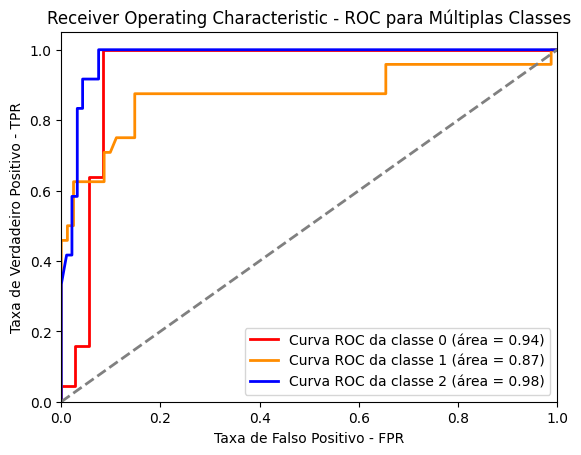

In [19]:
# Curva ROC e AUC
predictions = trainer.predict(test_dataset=tokenized_datasets['test']).predictions
labels = test_df['rotulo'].values

#Identifica os rótulos para a estratégia "one-vs-rest"
labels_bin = label_binarize(labels, classes=[0, 1, 2])

# Número de classes
n_classes = labels_bin.shape[1]

# Calculando a ROC e AUC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], predictions[:, i]) #Taxa de falsos positivos e verdadeiros positivos para diferentes limiares.
    roc_auc[i] = auc(fpr[i], tpr[i]) #Valor da área sob a curva ROC, que indica a capacidade do modelo em distinguir entre as classes.

# Plotagem da curva ROC para cada classe
plt.figure()
colors = ['red', 'darkorange', 'blue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Curva ROC da classe {i} (área = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--') # linha diagonal que representa um classificador aleatório (AUC = 0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo - FPR')
plt.ylabel('Taxa de Verdadeiro Positivo - TPR')
plt.title('Receiver Operating Characteristic - ROC para Múltiplas Classes')
plt.legend(loc='lower right')
plt.show()


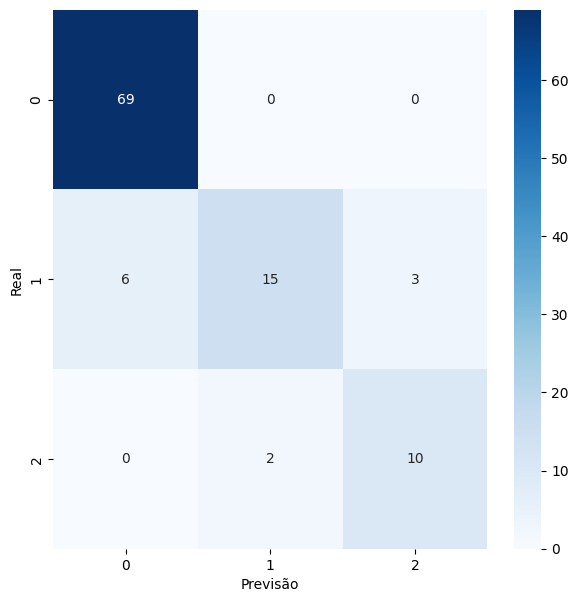

In [20]:
# Matriz de confusão (i, j) - Indica para cada valor que pertence a i, quantos foram classificados como j
predictions1 = trainer.predict(test_dataset=tokenized_datasets['test']).predictions
preds = np.argmax(predictions1, axis=1)
cm = confusion_matrix(test_df['rotulo'], preds)

plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

In [21]:
# Função para prever o rótulo de novas associações entre domínios e values
def predict_new_data(model, tokenizer, texts):
    # Tokenizar os novos textos
    inputs = tokenizer(texts, truncation=True, padding='max_length', max_length=128, return_tensors='pt') #Mesmos parâmetros da tokenização da base de treino
    inputs = {key: val.to(model.device) for key, val in inputs.items()}

    # Colocar o modelo em modo de avaliação
    model.eval()

    # Fazer as previsões
    with torch.no_grad():
        outputs = model(**inputs)

    # Extrair as previsões e logs
    logits = outputs.logits
    predictions = torch.argmax(logits, axis=-1)

    # Mapear as previsões para as classes originais
    class_mapping = {0: 'Inadequada', 1: 'Adequada', 2: 'Parcialmente adequada'}  # A ordem das classes pode precisar ser ajustada
    mapped_predictions = [class_mapping[pred.item()] for pred in predictions]

    # Calcular as probabilidades usando softmax
    probabilities = torch.nn.functional.softmax(logits, dim=1)

    return mapped_predictions,logits, probabilities


In [23]:
# Dados novos e aleatórios para classificação
new_texts = [
    "polícia - courthouse",
    "Edificação pública civil - prison",
    "Posto de combustível - fuel",
    "hotel - love_hotel",
    "motel - love_hotel",
    "escola - university",
    "banco - atm",
    "banco - bank",
    "curral - atm",
    "sinagoga - cathedral",
    "pousada - chalet",
    "mesquita - chalet",
    "filmes - cinema",
    "Escola - college"
]


In [24]:
# Chamar a função de previsão
predictions, logits, probabilities = predict_new_data(model, tokenizer, new_texts)

# Exibir as previsões
for text, pred, logit, prob in zip(new_texts, predictions, logits, probabilities):
    print(f"Associação semântica: {text} -> Classificação: {pred}\nLogit: {logit.tolist()}\nProbabilidade: {prob.tolist()}\n")


Associação semântica: polícia - courthouse -> Classificação: Adequada
Logit: [-2.3422467708587646, 2.2582454681396484, -0.1186126172542572]
Probabilidade: [0.009109609760344028, 0.9067097902297974, 0.08418060094118118]

Associação semântica: Edificação pública civil - prison -> Classificação: Adequada
Logit: [-2.448700428009033, 2.216925859451294, 0.30098187923431396]
Probabilidade: [0.008138696663081646, 0.8645910024642944, 0.12727023661136627]

Associação semântica: Posto de combustível - fuel -> Classificação: Adequada
Logit: [-2.2003657817840576, 2.2802157402038574, -0.22140257060527802]
Probabilidade: [0.010360417887568474, 0.9146795868873596, 0.07496006041765213]

Associação semântica: hotel - love_hotel -> Classificação: Inadequada
Logit: [3.678375005722046, -1.3891994953155518, -2.2616634368896484]
Probabilidade: [0.9911494255065918, 0.006241938564926386, 0.0026086338330060244]

Associação semântica: motel - love_hotel -> Classificação: Adequada
Logit: [-0.5529496669769287, 1.3